# Preprocess input for globygon

Read in old Roman and Euclid survey files and keep only what we need.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

degtorad = np.pi/180.

## First the easy survey (Roman)

In [12]:
# Can we use Pandas instead?
import pandas as pd

filename = "easysurvey.txt"
data = pd.read_csv(filename, comment='#', names=['ID', 'RA', 'DEC'], delimiter=' ')

print(data['ID'])

0       61239
1       62511
2       61076
3       61972
4       62007
        ...  
2995    62091
2996    62091
2997    61617
2998    62099
2999    61239
Name: ID, Length: 3000, dtype: int64


In [2]:
# Read the file I got from Chris Hirata on May 1, 2020 - this is Equatorial coords!
filepath = '../../../ResearchProjects/Systematics/Surveys/Roman_observing_sequence_hlsonly_5yr.dat'
with open(filepath,'r') as f:
    n = 0
    ID = []
    RA = []
    DEC = []
    PA = []
    FI = []
    for line in f:
        if line[0]!='#': 
            n+=1
            time,ra,dec,pa,fi = [float(line.split()[i]) for i in [0,3,4,5,7]]
            if n<4: print(time,ra,dec,pa,fi)
            ID.append(time)
            RA.append(ra)
            DEC.append(dec)
            PA.append(pa)
            FI.append(int(fi))
    print("---------\nNUMBER OF LINES IN FILE = ",n)
ID = np.array(ID)
RA = np.array(RA)
DEC = np.array(DEC)
print("---------\nNUMBER OF GRISM OBSERVATIONS = ",len(ID))

61013.000001 11.6658 -45.0979 347.68 9.0
61013.025582 11.6378 -45.0895 347.69 9.0
61013.029818 11.5469 -44.7126 347.67 9.0
---------
NUMBER OF LINES IN FILE =  229491
---------
NUMBER OF GRISM OBSERVATIONS =  229491


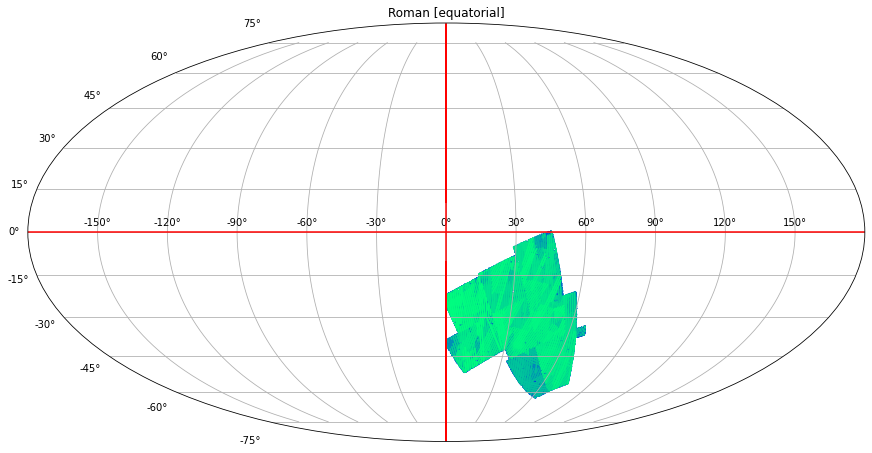

In [3]:
# make a gradual colour change according to epoch of observation
cm = plt.get_cmap('winter')
c = cm(1.*np.arange(n)/n)

# Make a plot on sky 
fig1 = plt.figure(figsize=[15,15])
ax1 = fig1.add_subplot(111, projection="mollweide")

ax1.scatter(RA*degtorad,DEC*degtorad,s=0.1,c=c)
ax1.plot([-np.pi, np.pi], [0,0],'r-') # equator
ax1.plot([0,0],[-np.pi, np.pi], 'r-') # Greenwich

plt.title("Roman [equatorial]")
plt.grid(True)

plt.show()

In [4]:
# Downselect and save
mask = np.random.choice(np.arange(n),3000)#int(n/100))

# Make an array
print(ID[mask].shape)
DATA = np.vstack((np.vstack((ID[mask],RA[mask])),DEC[mask]))
print(DATA.shape)

fname = "easysurvey.txt"
header = "# Sample easy astronomical survey (coordinates in degrees, equatorial)\n# ID RA DEC"
np.savetxt(fname, DATA.T, fmt='%d %f %f', delimiter=' ', newline='\n', header=header)

(3000,)
(3, 3000)


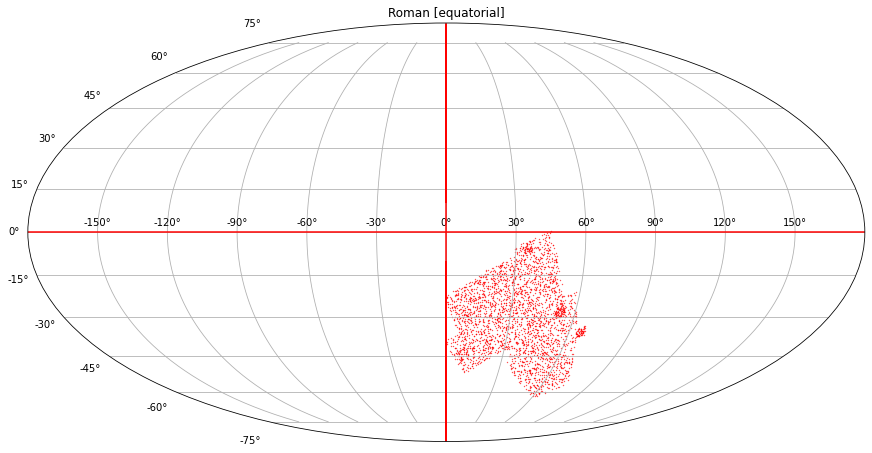

In [5]:
# Plot again to check
fig2 = plt.figure(figsize=[15,15])
ax1 = fig2.add_subplot(111, projection="mollweide")

ax1.scatter(RA[mask]*degtorad,DEC[mask]*degtorad,s=0.1,c='r')
ax1.plot([-np.pi, np.pi], [0,0],'r-') # equator
ax1.plot([0,0],[-np.pi, np.pi], 'r-') # Greenwich

plt.title("Roman [equatorial]")
plt.grid(True)

plt.show()

## Now the complicated one (Euclid)

In [6]:
# Read the file
filepath = '../../../ResearchProjects/Systematics/Surveys/Euclid_survey.dat'
with open(filepath,'r') as f:
    n = 0
    ID = []
    RA = []
    DEC = []
    PA = []
    for line in f:
        if line[0]!='#': 
            n+=1
            time,ra,dec,pa = [float(line.split()[i]) for i in [1,2,3,4]]
            if n<4: print(time,ra,dec,pa)
            ID.append(time)
            RA.append(ra)
            DEC.append(dec)
            PA.append(pa)
    print("---------\nNUMBER OF LINES IN FILE = ",n)
ID = np.array(ID)
RA = np.array(RA)
DEC = np.array(DEC)

7472.0 354.100726 89.113678 80.90839
7472.008301 354.100951 89.377191 76.311666
7472.01709 354.100965 89.640226 75.800406
---------
NUMBER OF LINES IN FILE =  42749


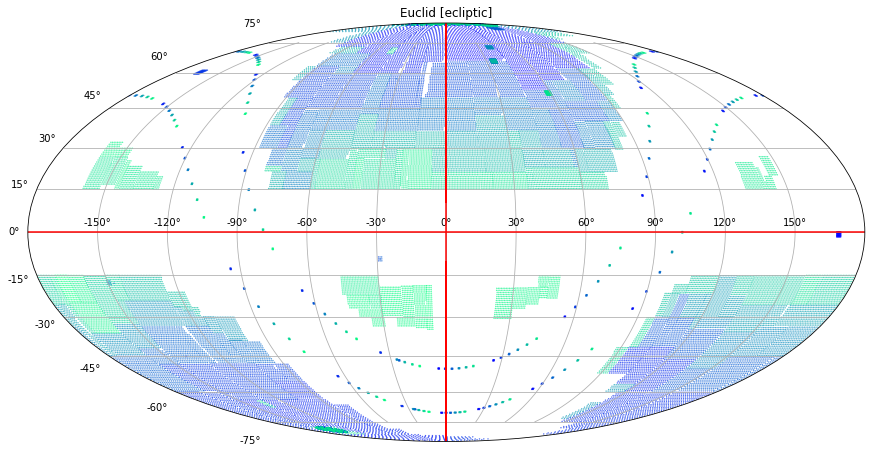

In [7]:
# make a gradual colour change according to epoch of observation
cm = plt.get_cmap('winter')
c = cm(1.*np.arange(n)/n)

# Make a plot on sky 
fig1 = plt.figure(figsize=[15,15])
ax1 = fig1.add_subplot(111, projection="mollweide")

ax1.scatter((RA-180)*degtorad,DEC*degtorad,s=0.1,c=c) # stupid plot
ax1.plot([-np.pi, np.pi], [0,0],'r-') # equator
ax1.plot([0,0],[-np.pi, np.pi], 'r-') # anti-Greenwich

plt.title("Euclid [ecliptic]")
plt.grid(True)

plt.show()

In [8]:
# Keep only the main regions
from astropy import units as u
from astropy.coordinates import SkyCoord

# Remove everything within 15 degrees of the ecliptic
mask = np.abs(DEC)>15

# Now remove everything within n degrees of the galactic equator

# First convert to galactic coords using Astropy (ICRS is ecliptic)
coords = SkyCoord(lon=RA*u.degree, lat=DEC*u.degree, frame='geocentrictrueecliptic')
coords = coords.galactic

mask = mask*(np.abs(coords.b)>15*u.degree)

# Now to equatorial
coords = coords.geocentrictrueecliptic

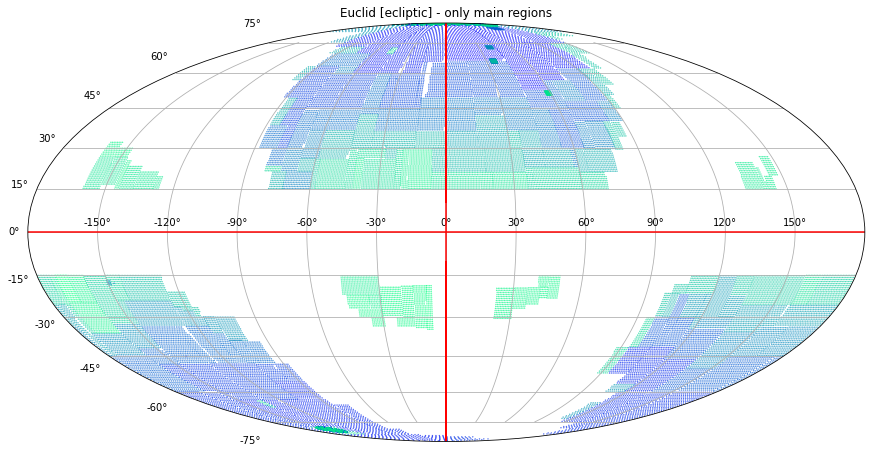

In [9]:
# Now plot to see if it makes sense
fig1 = plt.figure(figsize=[15,15])
ax1 = fig1.add_subplot(111, projection="mollweide")

ax1.scatter((coords.lon[mask]-np.pi*u.radian)*degtorad,coords.lat[mask]*degtorad,s=0.1,c=c[mask]) # pointings
ax1.plot([-np.pi, np.pi], [0,0],'r-') # celestial equator
ax1.plot([0,0],[-np.pi, np.pi], 'r-') # celestial Greenwich

plt.title("Euclid [ecliptic] - only main regions")
plt.grid(True)

plt.show()

In [10]:
# Downselect and save
ID = ID[mask]
RA = np.array(coords.lon[mask])
DEC = np.array(coords.lat[mask])
n = len(RA)

mask = np.random.choice(np.arange(n),3000)#int(n/100))

# Make an array
print(ID[mask].shape)
DATA = np.vstack((np.vstack((ID[mask],RA[mask])),DEC[mask]))
print(DATA.shape)

fname = "hardsurvey.txt"
header = "# Sample hard astronomical survey (coordinates in degrees, ecliptic)\n# ID RA DEC"
np.savetxt(fname, DATA.T, fmt='%d %f %f', delimiter=' ', newline='\n', header=header)

(3000,)
(3, 3000)


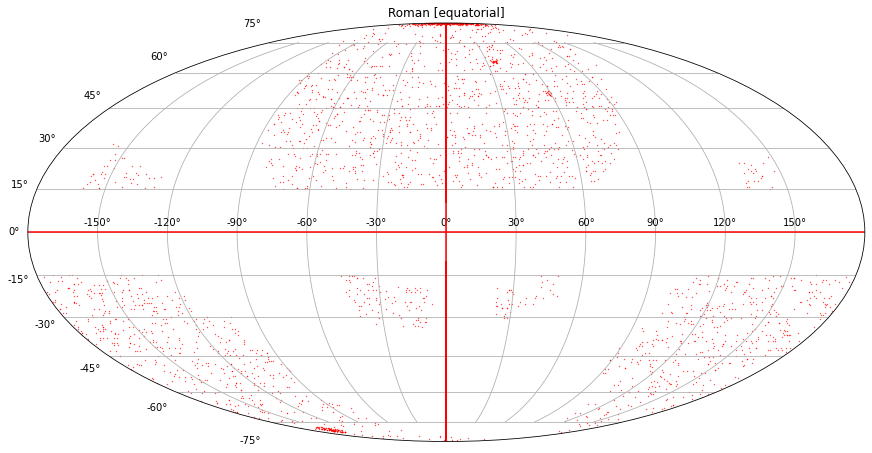

In [12]:
# Plot again to check
fig2 = plt.figure(figsize=[15,15])
ax1 = fig2.add_subplot(111, projection="mollweide")

ax1.scatter((RA[mask]-180)*degtorad,DEC[mask]*degtorad,s=0.1,c='r') # pointings
ax1.plot([-np.pi, np.pi], [0,0],'r-') # equator
ax1.plot([0,0],[-np.pi, np.pi], 'r-') # anti-Greenwich

plt.title("Roman [equatorial]")
plt.grid(True)

plt.show()

Dida Markovic, 2021

### Calculating the center-of-mass for the points

1. Convert each coordinate in RA $(\alpha_{\rm i})$/Dec $(\delta_{\rm i})$ to $x_{\rm i}$, $y_{\rm i}$, and $z_{\rm i}$ Cartesian coordinates: <br>
$$ 
x_{\rm i} = \sin\left( 90^\circ - \delta_{\rm i} \right) \cos \left( \alpha_{\rm i} \right), \\ 
y_{\rm i} = \sin\left( 90^\circ - \delta_{\rm i}  \right) \sin \left( \alpha_{\rm i} \right), \\
z_{\rm i} = \cos\left( 90^\circ - \delta_{\rm i}  \right)
$$
2. Calculate the center-of-mass using the Cartesian coordinates, of which there are $N$ points:
$$
\langle x \rangle = \sum_{\rm i}^{\rm N} x_{\rm i}/N.
$$
3. Convert the $\langle x \rangle$/$\langle y \rangle$/$\langle z \rangle$ back into polar coordinates:
$$
\langle \delta \rangle = 90^\circ - \sin^{-1} \left( \langle x \rangle^2 + \langle y \rangle^2 \right)\\
\langle \alpha \rangle = \tan^{-1} \left( \langle x \rangle/\langle y \rangle \right).
$$
(These equations will give us some quadrant problems that we'll have to solve.)